# 03_Propagation-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-04-28 17:33:02.696525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-28 17:33:02.697298: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-28 17:33:02.697492: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

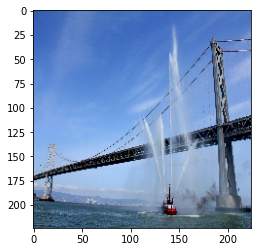

In [4]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [6]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

fireboat: 98.6%
drilling platform: 0.3%
crane: 0.2%


## [LRP (Bach et al. 15)](https://arxiv.org/abs/1604.00825)

In [18]:
layers = model.layers
L = len(layers)
X = preprocess_input(tf.expand_dims(image, 0))

<h3>2.1 &nbsp; Predicting the class of an image</h3>

<p>The input can then be propagated in the network and the activations at each layer are collected:</p>

In [23]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].call(A[l])

<p>Activations in the top layer are the scores the neural network predicts for each class. We show below the 10 classes with highest score:</p>

In [66]:
scores = np.squeeze(A[-1].numpy())
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(imagenet_labels[i], i, scores[i]))

            fireboat (554):  0.986
   drilling platform (540):  0.003
               crane (517):  0.002
                pier (718):  0.002
      container ship (510):  0.001
               liner (628):  0.001
            schooner (780):  0.001
                dock (536):  0.001
   steel arch bridge (821):  0.000
   suspension bridge (839):  0.000


<p>We observe that the neuron castle (index 483) has the highest score. This is expected due to the presence of a castle in the image. Note that other building-related classes are also assigned a high score, as well as classes corresponding to other objects present in the image (e.g. street sign and traffic light).</p>

<h3>2.2 &nbsp; Explaining the prediction with LRP</h3>

<p>The following code iterates from the top layer to the first layer in reverse order and applies propagation rules at each layer. Top-layer activations are first multiplied by the mask to retain only the predicted evidence for the class "castle".</p>

In [15]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]

<p>This evidence can then be propagated backward in the network by applying propagation rules at each layer.</p>

<p><b>Convolution layers:</b> Observing that convolutions are special types of linear layers, we can use the same propagation rules as in the MNIST example, and a similar four-step procedure for applying these rules. Steps 2 and 4 are simple element-wise computations. Step 1 can be implemented as a forward computation in the layer, where we have preliminary transformed the layer parameters, and where we apply the increment function afterwards. As shown in the LRP overview paper, Step 3 can instead be computed as a gradient in the space of input activations:</p>

<img src="http://latex.codecogs.com/svg.latex?c_j = \big[\nabla~\big({\textstyle \sum_k}~z_k(\boldsymbol{a}) \cdot s_k\big)\big]_j">

<p>where <i>s<sub>k</sub></i> is treated as constant.</p>

<p><b>Pooling layers:</b> It is suggested in Section 10.3.2 of the paper to treat max-pooling layers as average pooling layers in the backward pass. Observing that average pooling is also a special linear layer, the same propagation rules as for the convolutional layers become applicable.</p>

<p>In the following code, we iterate the propagation procedure from the top-layer towards the lower layers. Whenever we meet a max-pooling layer, we convert it into an average pooling layer. The function <code>rho</code> and <code>incr</code> are set differently at each layer, following the strategy of Section 10.3.</p>

In [ ]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]

As each layer is composed of a collection of two-dimensional feature maps, relevance scores at each layer can be visualized as a two-dimensional map. Here, relevance scores are pooled over all feature maps at a given layer. The two-dimensional maps are shown for a selection of VGG-16 layers.

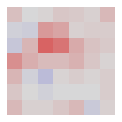

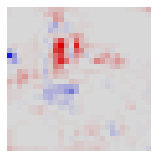

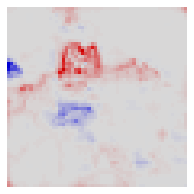

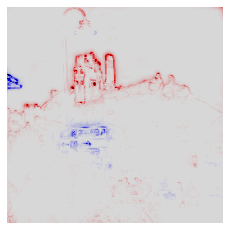

In [17]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

<p>We observe that the explanation becomes increasingly resolved spatially. Note that, like for the MNIST example, we have stopped the propagation procedure one layer before the pixels because the rule we have used is not applicable to pixel layers. Like for the MNIST case, we need ot apply the pixel-specific zB-rule for this last layer. This rule can again be implemented in terms of forward passes and gradient computations.</p>

In [18]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

The relevance scores obtained in the pixel layer can now be summed over the RGB channels to indicate actual pixel-wise contributions.

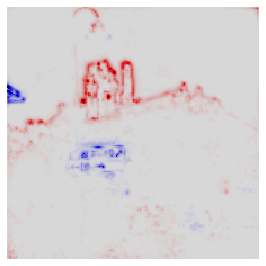

In [19]:
utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

We observe that the heatmap highlights the outline of the castle as evidence for the corresponding class. Some elements such as the traffic sign or the roof on the left are seen as having a negative effect on the neuron "castle" and are consequently highlighted in blue.